# Extracting BERT Embeddings
Adapted from https://www.kaggle.com/code/maostack/clrp-how-to-get-text-embedding-from-roberta
and
https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX#scrollTo=1RfUN_KolV-f

In [4]:
!pip install torch
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 14.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 10.8 MB/s eta 0:00:0000:0100:01


In [1]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import RobertaModel, RobertaTokenizer

In [2]:
class Settings:
    batch_size=16
    max_len=512 # originally 350?
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seed = 318

In [3]:
class TrainValidDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, text_column):
        self.df = df
        self.text = df[text_column].values
        self.target = df["target"].values
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        texts = self.text[idx]
        tokenized = self.tokenizer.encode_plus(texts, truncation=True, add_special_tokens=True,
                                               max_length=self.max_len, padding="max_length")
        ids = tokenized["input_ids"]
        mask = tokenized["attention_mask"]
        targets = self.target[idx]
        return {
            "ids": torch.LongTensor(ids),
            "mask": torch.LongTensor(mask),
            "targets": torch.tensor(targets, dtype=torch.float32)
        }

In [4]:
# LOAD ROBERTA TOKENIZER AND MODEL
from transformers import RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaModel.from_pretrained('roberta-large')
model.to(Settings.device)

tokenizer

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaTokenizer(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

# Extraction I

In [6]:
from tqdm import tqdm
# prepare dataset
# データセットを準備
df_train = pd.read_csv("VET_Corpus_for_Embeddings.csv", index_col=0)

train_dataset = TrainValidDataset(df_train, tokenizer, Settings.max_len)

# DATALOADER NOT DETERMINISTIC?? BATCHING DIFFERENTLY EVERYTIME? TRY TO DO JUST ONE TEXT SAMPLE AT A TIME??? SEE __GETITEM__ IN DATASET FUNCTION
train_loader = DataLoader(train_dataset, batch_size=Settings.batch_size,
                          shuffle=False, num_workers=8, pin_memory=True)

#         texts = self.text[idx]
#         tokenized = self.tokenizer.encode_plus(texts, truncation=True, add_special_tokens=True,
#                                                max_length=self.max_len, padding="max_length")
#         ids = tokenized["input_ids"]
#         mask = tokenized["attention_mask"]
#         targets = self.target[idx]
#         return {
#             "ids": torch.LongTensor(ids),
#             "mask": torch.LongTensor(mask),
#             "targets": torch.tensor(targets, dtype=torch.float32)
#         }

df_train['CLS_Embedding'] = pd.np.empty((len(df_train), 0)).tolist()
df_train['Pooled_Embedding'] = pd.np.empty((len(df_train), 0)).tolist() # last hidden layer, average pooled across all tokens ...
display(df_train.head())

curr_index = 0 # index at which to insert embeddings
for batch in tqdm(iter(train_loader), position=0, leave=True): # for every batch in this dataset (should be (num_rows / 16) ~= 123 batches)
    # batch = next(iter(train_loader))
    ids = batch["ids"].to(Settings.device)
    mask = batch["mask"].to(Settings.device)
    targets = batch["targets"].to(Settings.device)
    # print(ids.shape) # torch.Size([16, 512]) ([BATCH_SIZE, MAX_LENGTH])
    # print(mask.shape) # torch.Size([16, 512])
    # print(targets.shape) # torch.Size([16])

    # *** GET THE OUTPUTS from this batch ***
    output = model(ids, mask)
    # output
    # last_hidden_state
    # last_hidden_state = output[0]
    # print("shape:", last_hidden_state.shape) # shape: torch.Size([16, 512, 768])

    # last_hidden_state
    last_hidden_state = output[0]
    # print("shape:", last_hidden_state.shape)

    # *** [CLS] TOKEN EMBEDDINGS ***
    # .detach() = make copies and remove gradient information  
    # .detach() = 勾配情報を除外してテンソルをコピー
    cls_embeddings = last_hidden_state[:, 0, :].detach()
    # print("shape:", cls_embeddings.shape)
    # print("")
    # print(len(cls_embeddings))
    # print(cls_embeddings)
    
    # *** POOLED TOKEN EMBEDDINGS ***
    # pooling last hidden layer; ie, avg. pooling of all tokens in last layer to obtain one 768-dimension embedding
    # last_hidden_state.shape # torch.Size([16, 512, 768])
    # apply avg.pooling to word embeddings
    # 単語埋め込みベクトルにaverage pooling を適用する
    pooled_embeddings = last_hidden_state.detach().mean(dim=1)
    # print("shape:", pooled_embeddings.shape)
    # print("")
    # print(pooled_embeddings)
    
    # go through each example in the batch and add the embeddings to the DataFrame
    for x in range(0, len(batch['ids'])):
        # print(type(np.array(cls_embeddings[x])))
        df_train.at[curr_index, 'CLS_Embedding'] = cls_embeddings[x].tolist()
        df_train.at[curr_index, 'Pooled_Embedding'] = pooled_embeddings[x].tolist()
        curr_index += 1
    # print(len(cls_embeddings))
    # print(len(pooled_embeddings))
    # print(pooled_embeddings[16])
    # break
    # batch_embeddings = pd.DataFrame(pooled_embeddings.numpy()).head()
df_train

TypeError: __init__() missing 1 required positional argument: 'text_column'

In [15]:
# verify that row 0 has same embeddings when run individually vs batches (also serves as function to obtain individual-text-embedding)
s = df_train.loc[0, 'excerpt']
tokenized = tokenizer.encode_plus(s, truncation=True, add_special_tokens=True,
                                       max_length=512, padding="max_length")
ids = [tokenized["input_ids"]]
mask = [tokenized["attention_mask"]]
ids = torch.LongTensor(ids).to('cuda')
mask = torch.LongTensor(mask).to('cuda')

output = model(ids, mask)

# last_hidden_state
last_hidden_state = output[0]

# *** [CLS] TOKEN EMBEDDINGS ***
cls_embeddings = last_hidden_state[:, 0, :].detach()

# *** POOLED TOKEN EMBEDDINGS ***
pooled_embeddings = last_hidden_state.detach().mean(dim=1)

print(cls_embeddings[0][0:2]) # check with row 0 in batched DataFrame
print(pooled_embeddings[0][0:2])

tensor([-0.0716,  0.0109], device='cuda:0')
tensor([-0.0378, -0.0574], device='cuda:0')


In [16]:
df_train.to_csv("RoBERTa_Embeddings.csv")

In [ ]:
PROPERTY = 'is_vague' # will separate df into parts based off this property
pos_df = df_train.loc[df_train[PROPERTY]==1]
neg_df = df_train.loc[df_train[PROPERTY]==0]

# Visualizing the Embeddings

# Embedding + Visualization (More Concise)

In [ ]:
# for every example i need the INDEX IDs - reef

In [7]:
from tqdm import tqdm
# ******** adjust settings below **********
df_train = pd.read_csv("VET_Corpus_for_Embeddings.csv", index_col=0)
target_column = 'excerpt' # the column in the df containing the text to be embedded
embed_target = 'full_text' # name of desired embeddings
# *****************************************

# ADD BRACKETS?
# for i, row in df_train.iterrows():
#     df_train.at[i, 'keyword'] = "<" + df_train.at[i, 'keyword'] + ">" # MWEs??
    
# cls_embed_column = embed_target + '_CLS_Embedding'
# pool_embed_column = embed_target + '_Pool_Embedding'
pet_embed_column = embed_target + '_PET_Embedding'

train_dataset = TrainValidDataset(df_train, tokenizer, Settings.max_len, target_column)

# DATALOADER NOT DETERMINISTIC?? BATCHING DIFFERENTLY EVERYTIME? TRY TO DO JUST ONE TEXT SAMPLE AT A TIME??? SEE __GETITEM__ IN DATASET FUNCTION
train_loader = DataLoader(train_dataset, batch_size=Settings.batch_size,
                          shuffle=False, num_workers=8, pin_memory=True)

# df_train[cls_embed_column] = pd.np.empty((len(df_train), 0)).tolist()
# df_train[pool_embed_column] = pd.np.empty((len(df_train), 0)).tolist() # last hidden layer, average pooled across all tokens ...
df_train[pet_embed_column] = pd.np.empty((len(df_train), 0)).tolist()
# display(df_train.head())

curr_index = 0 # index at which to insert embeddings
# for batch in tqdm(iter(train_loader), position=0, leave=True): # for every batch in this dataset (should be (num_rows / 16) ~= 123 batches)
#     ids = batch["ids"].to(Settings.device)
#     mask = batch["mask"].to(Settings.device)
#     targets = batch["targets"].to(Settings.device)

#     # *** GET THE OUTPUTS from this batch ***
#     output = model(ids, mask)
#     # last_hidden_state
#     last_hidden_state = output[0]
    
#     # *** [CLS] TOKEN EMBEDDINGS ***
#     cls_embeddings = last_hidden_state[:, 0, :].detach()
#     # *** POOLED TOKEN EMBEDDINGS ***
#     pooled_embeddings = last_hidden_state.detach().mean(dim=1)
    
#     # go through each example in the batch and add the embeddings to the DataFrame
#     for x in range(0, len(batch['ids'])):
#         df_train.at[curr_index, cls_embed_column] = cls_embeddings[x].tolist()
#         df_train.at[curr_index, pool_embed_column] = pooled_embeddings[x].tolist()
#         curr_index += 1

for i in tqdm(range(0, len(train_dataset)), position=0, leave=True): # for every batch in this dataset (should be (num_rows / 16) ~= 123 batches)
    example = train_dataset[i]
    ids = example["ids"].to(Settings.device)
    mask = example["mask"].to(Settings.device)
    targets = example["targets"].to(Settings.device)

    # *** GET THE OUTPUTS from this batch ***
    output = model(ids, mask)
    # last_hidden_state
    last_hidden_state = output[0]
    
    # *** [CLS] TOKEN EMBEDDINGS ***
    cls_embeddings = last_hidden_state[:, 0, :].detach()
    # *** POOLED TOKEN EMBEDDINGS ***
    pooled_embeddings = last_hidden_state.detach().mean(dim=1)
    
    # go through each example in the batch and add the embeddings to the DataFrame
    for x in range(0, len(batch['ids'])):
        df_train.at[curr_index, cls_embed_column] = cls_embeddings[x].tolist()
        df_train.at[curr_index, pool_embed_column] = pooled_embeddings[x].tolist()
        curr_index += 1
df_train

/home/leep/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  0%|          | 0/1965 [00:00<?, ?it/s]

{'ids': tensor([    0,   170,   214,    95,   562,   124,    99,    21,   255,  7140,
         2796,    31,   201,    31,    10, 34405,   394,    54,   129,    56,
            5,  6281,    11,  1508,     6, 36511,   459,   159,   866,   127,
          787, 42654,     6,    24,    21,     5,    12,  3006,    15,    47,
          866,    13,   290,   107,     6, 28696,   565, 15673, 15698,    15,
           47,   866,     6,     5,  5579,    24, 12357, 19966,   866,   223,
         3516,     6,     8,  6973,  7588,     7,   489,    24,   164,     4,
         1336,    47,  1669,    64,   323,    14,    16,  1508,   741,  6038,
         1527, 44629,  1892,    77,    39,   964,  3148,  3370,     7,    24,
           18,  3433,   477,     8,    37,   115,   117,  1181,  7433,     5,
          754,    14,    52,    58,   416,    11,    10,  7306,  5988,   396,
         2086,    99,   410, 10796,    37,    56,   314,    19,     5,   235,
         5897,    37,  2966,  3370,     7,  4852,   106,

,keyword,excerpt,target,category,type,euph_status,sentence,is_vague,full_text_PET_Embedding
0,tinkle,We're just getting back what was TAKEN from us...,1,bodily functions,tinkle,always_euph,We're just getting back what was TAKEN from us...,0,[]
1,tinkle,I think AB390 will pass next year now that the...,1,bodily functions,tinkle,always_euph,I think AB390 will pass next year now that the...,0,[]
2,undocumented immigrants,"Singled Out Think Like a Man, the new movie ba...",1,politics,undocumented immigrant,always_euph,Anything but Secure A federal program designed...,0,[]
3,undocumented immigrants,"Not to be outdone, Sen. Rand Paul (R-Ky. ), so...",1,politics,undocumented immigrant,always_euph,In a post-election interview with POLITICO Pau...,0,[]
4,undocumented immigrants,The law has also galvanized the growing immigr...,1,politics,undocumented immigrant,always_euph,Aside from undocumented immigrants the America...,0,[]
...,...,...,...,...,...,...,...,...,...
1960,sleep with,There were other photos she wanted me to see: ...,0,sexual activity,sleep with,sometimes_euph,There were other photos she wanted me to see B...,0,[]
1961,sleep with,I am relieved to see two pup tents marked STAF...,0,sexual activity,sleep with,sometimes_euph,Thank God I don't have to sleep with Ace Wands,0,[]
1962,sleep around,"Nothing serious, just long nights of me hackin...",0,sexual activity,sleep around,sometimes_euph,With all my caterwauling it's a wonder anyone ...,0,[]
1963,with child,sounds more like Jonestown. They cant leave @ ...,0,physical/mental attributes,with child,sometimes_euph,They cant leave best advice I can give them is...,0,[]


In [59]:
# here, I turn a 52x768 list of tensors into a 52x2 2D-numpy-array for plotting.
from sklearn.decomposition import PCA
import numpy as np

X = np.zeros(shape=(len(df_train), 768))
for t in range(0, len(df_train)):
    X[t] = np.array(df_train.loc[t, cls_embed_column]) # array of arrays
print("Before PCA: {} x {}".format(len(X), len(X[0])))

y = PCA(n_components=2).fit_transform(X)
print("After PCA: {} x {}".format(len(y), len(y[0])))
y # has the PCA'd components of an embedding column

Before PCA: 1965 x 768
After PCA: 1965 x 2


array([[ 0.13565396,  0.03388774],
       [ 0.13565396,  0.03388774],
       [-0.12104703, -0.02020503],
       ...,
       [-0.03323159,  0.01525876],
       [-0.15327431, -0.02670892],
       [-0.15327431, -0.02670892]])

In [ ]:
# OPTIONALLY save PCA embeddings to DataFrame
df_train['PCA_' + embed_target] = pd.np.empty((len(df_train), 0)).tolist() # initialize column
df_train['PCA_' + embed_target + '_x'] = pd.np.empty((len(df_train), 0)).tolist() # this contains the X (1st) coordinate of the PCA'd embeddings; may be useful for analysis
df_train['PCA_' + embed_target + '_y'] = pd.np.empty((len(df_train), 0)).tolist() # this contains the Y (2nd) coordinate of the PCA'd embeddings; may be useful for analysis

for x in range(0, len(y)):
    # print(y[x].tolist())
    df_train.at[x, 'PCA_' + embed_target] = y[x].tolist()
    df_train.at[x, 'PCA_' + embed_target + '_x'] = y[x][0]
    df_train.at[x, 'PCA_' + embed_target + '_y'] = y[x][1]
    
df_train.to_csv("RoBERTa_" + embed_target + ".csv")

In [60]:
PROPERTY = 'target'
pos_value = 1 # other options: 'always_euph'
neg_value = 0 # 'sometimes_euph'
pos_df = df_train.loc[df_train['is_vague'] == pos_value]
neg_df = df_train.loc[df_train['is_vague'] == neg_value]

vague_1s = pos_df.loc[pos_df[PROPERTY] == pos_value]
vague_0s = pos_df.loc[pos_df[PROPERTY] == neg_value]
unvague_1s = neg_df.loc[neg_df[PROPERTY] == pos_value]
unvague_0s = neg_df.loc[neg_df[PROPERTY] == neg_value]

y_v1 = np.take(y, vague_1s.index.astype(int), axis=0)
y_v0 = np.take(y, vague_0s.index.astype(int), axis=0)
y_uv1 = np.take(y, unvague_1s.index.astype(int), axis=0)
y_uv0 = np.take(y, unvague_0s.index.astype(int), axis=0)
# y_pos = np.take(y, pos_df.index.astype(int), axis=0)
# y_neg = np.take(y, neg_df.index.astype(int), axis=0)

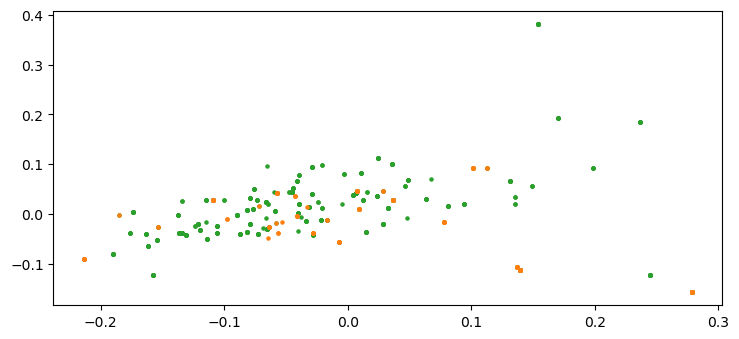

In [63]:
import numpy as np
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Random data of 100×3 dimension
# data = np.array(np.random.random((100, 3)))

# Scatter plot
# fig = plt.scatter(y_pos[:,0], y_pos[:,1], c='tab:red', s=5) # [:,0] I think means: the 0th element of every datapoint (x-coordinate)
# fig = plt.scatter(y_neg[:,0], y_neg[:,1], c='tab:blue', s=5)

fig = plt.scatter(y_uv1[:,0], y_uv1[:,1], c='tab:green', s=5) 
fig = plt.scatter(y_uv0[:,0], y_uv0[:,1], c='tab:orange', s=5)
# fig = plt.scatter(y_v1[:,0], y_v1[:,1], c='tab:red', s=5) # [:,0] I think means: the 0th element of every datapoint (x-coordinate)
# fig = plt.scatter(y_v0[:,0], y_v0[:,1], c='tab:blue', s=5)
# Display the plot
plt.show()

In [41]:
fig.figure.savefig('PET_Embeddings_CLS_Label_and_Vague.png')

# Extracting PET Embeddings in Context

In [5]:
import re
from tqdm import tqdm
# ******** adjust settings below **********
df_train = pd.read_csv("VET_Corpus_for_Embeddings.csv", index_col=0)
target_column = 'excerpt' # the column in the df containing the text to be embedded
embed_target = 'context' # name of desired embeddings
# *****************************************

# ADD BRACKETS?
# for i, row in df_train.iterrows():
#     df_train.at[i, 'keyword'] = "<" + df_train.at[i, 'keyword'] + ">" # MWEs??
pet_embed_column = embed_target + '_PET_Embedding'

train_dataset = TrainValidDataset(df_train, tokenizer, Settings.max_len, target_column)

# DATALOADER NOT DETERMINISTIC?? BATCHING DIFFERENTLY EVERYTIME? TRY TO DO JUST ONE TEXT SAMPLE AT A TIME??? SEE __GETITEM__ IN DATASET FUNCTION
train_loader = DataLoader(train_dataset, batch_size=Settings.batch_size,
                          shuffle=False, num_workers=8, pin_memory=True)

df_train[pet_embed_column] = pd.np.empty((len(df_train), 0)).tolist()
# display(df_train.head())

curr_index = 0 # index at which to insert embeddings

for i in tqdm(range(0, len(train_dataset)), position=0, leave=True): # for every batch in this dataset (should be (num_rows / 16) ~= 123 batches)
    example = train_dataset[i]
    
    ids = example["ids"].to(Settings.device)
    ids = ids.unsqueeze(0)# unsqueeze adds a batch dimension (which is needed, apparently..?)
    mask = example["mask"].to(Settings.device)
    mask = mask.unsqueeze(0)
    targets = example["targets"].to(Settings.device)

    # what we should probably end up doing is converting < and > to [START_PET] and [END_PET] special bert tokens
    tokenized = tokenizer.convert_ids_to_tokens(ids[0])
    tokenized = [token.replace('Ġ', '') for token in tokenized]
    # tokenized = [token.replace('>.', '>') for token in tokenized]
    # tokenized = [token.replace('>,', '>') for token in tokenized]
    # tokenized = [token.replace('>?', '>') for token in tokenized]
    tokenized = [re.sub(r'[\"\'\?\!\.\,\(\):;]<', '<', token) for token in tokenized]
    tokenized = [re.sub(r'>[\"\'\?\!\.\,\(\):;]', '>', token) for token in tokenized]
    try:
        PET_start_index = tokenized.index('<') + 1
        PET_end_index = tokenized.index('>')
    except:
        print("ERROR:")
        print(tokenized)
        break
    # *** GET THE OUTPUTS from this batch ***
    output = model(ids, mask)
    # last_hidden_state
    last_hidden_state = output[0] # hidden_state is tensor with dimensions (batch_size (1 if no batching used), seq_len (512 with padding), hidden_dim (1024 for roberta-lage))
    # *** PET EMBEDDINGS ***
    PET_embeddings = last_hidden_state[:, PET_start_index:PET_end_index, :].detach()
    # print(last_hidden_state.shape)
    # print(PET_embeddings)
    # print(PET_embeddings.shape)
    # *** POOLED PET EMBEDDINGS ***
    pooled_embeddings = PET_embeddings.detach().mean(dim=1)
    # print(pooled_embeddings)
    # print(pooled_embeddings.shape)
    
    # go through each example in the batch and add the embeddings to the DataFrame
    # for x in range(0, len(batch['ids'])):
        # df_train.at[curr_index, cls_embed_column] = cls_embeddings[x].tolist()
    df_train.at[curr_index, pet_embed_column] = pooled_embeddings.squeeze(0).tolist()
    curr_index += 1
df_train

/home/leep/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
100%|██████████| 1965/1965 [01:18<00:00, 24.91it/s]


,keyword,excerpt,target,category,type,euph_status,sentence,is_vague,context_PET_Embedding
0,tinkle,We're just getting back what was TAKEN from us...,1,bodily functions,tinkle,always_euph,We're just getting back what was TAKEN from us...,0,"[-0.30876338481903076, -0.013457220047712326, ..."
1,tinkle,I think AB390 will pass next year now that the...,1,bodily functions,tinkle,always_euph,I think AB390 will pass next year now that the...,0,"[-0.22399751842021942, 0.09726563096046448, 0...."
2,undocumented immigrants,"Singled Out Think Like a Man, the new movie ba...",1,politics,undocumented immigrant,always_euph,Anything but Secure A federal program designed...,0,"[-0.022885676473379135, 0.0710124596953392, -0..."
3,undocumented immigrants,"Not to be outdone, Sen. Rand Paul (R-Ky. ), so...",1,politics,undocumented immigrant,always_euph,In a post-election interview with POLITICO Pau...,0,"[-0.14059889316558838, -0.2268732637166977, -0..."
4,undocumented immigrants,The law has also galvanized the growing immigr...,1,politics,undocumented immigrant,always_euph,Aside from undocumented immigrants the America...,0,"[0.10562705248594284, -0.05226028710603714, -0..."
...,...,...,...,...,...,...,...,...,...
1960,sleep with,There were other photos she wanted me to see: ...,0,sexual activity,sleep with,sometimes_euph,There were other photos she wanted me to see B...,0,"[-0.3158261179924011, -0.2724025249481201, -0...."
1961,sleep with,I am relieved to see two pup tents marked STAF...,0,sexual activity,sleep with,sometimes_euph,Thank God I don't have to sleep with Ace Wands,0,"[-0.09671621024608612, -0.2392652928829193, -0..."
1962,sleep around,"Nothing serious, just long nights of me hackin...",0,sexual activity,sleep around,sometimes_euph,With all my caterwauling it's a wonder anyone ...,0,"[0.06685589253902435, -0.04392580687999725, -0..."
1963,with child,sounds more like Jonestown. They cant leave @ ...,0,physical/mental attributes,with child,sometimes_euph,They cant leave best advice I can give them is...,0,"[-0.23283523321151733, 0.004665573593229055, -..."


In [16]:
# here, I turn a 52x768 list of tensors into a 52x2 2D-numpy-array for plotting.
from sklearn.decomposition import PCA
import numpy as np

X = np.zeros(shape=(len(df_train), 1024))
for t in range(0, len(df_train)):
    X[t] = np.array(df_train.loc[t, pet_embed_column]) # array of arrays
print("Before PCA: {} x {}".format(len(X), len(X[0])))

y = PCA(n_components=3).fit_transform(X)
print("After PCA: {} x {}".format(len(y), len(y[0])))
y # has the PCA'd components of an embedding column

Before PCA: 1965 x 1024
After PCA: 1965 x 3


array([[-2.22055852,  1.15800246, -0.29496813],
       [-2.02232814,  0.86224899, -0.29630978],
       [ 2.67333362, -3.04969393, -0.21730595],
       ...,
       [-2.15751405,  0.66422009,  0.39007002],
       [-1.06766608,  0.18879595, -0.31431852],
       [-2.35553849,  1.40551748,  0.08630629]])

In [28]:
# OPTIONALLY save PCA embeddings to DataFrame
embed_target = 'Contextual_3D_PET_Embedding'
df_train['PCA_' + embed_target] = pd.np.empty((len(df_train), 0)).tolist() # initialize column
df_train['PCA_' + embed_target + '_x'] = pd.np.empty((len(df_train), 0)).tolist() # this contains the X (1st) coordinate of the PCA'd embeddings; may be useful for analysis
df_train['PCA_' + embed_target + '_y'] = pd.np.empty((len(df_train), 0)).tolist() # this contains the Y (2nd) coordinate of the PCA'd embeddings; may be useful for analysis

for x in range(0, len(y)):
    # print(y[x].tolist())
    df_train.at[x, 'PCA_' + embed_target] = y[x].tolist()
    df_train.at[x, 'PCA_' + embed_target + '_x'] = y[x][0]
    df_train.at[x, 'PCA_' + embed_target + '_y'] = y[x][1]
    
df_train.to_csv("RoBERTa_" + embed_target + ".csv")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """


In [4]:
import pandas as pd
import numpy as np
import ast
df_train = pd.read_csv("RoBERTa_Contextual_3D_PET_Embedding.csv", index_col=0)

y = []
for i, row in df_train.iterrows():
    embed = ast.literal_eval(df_train.loc[i, 'PCA_Contextual_3D_PET_Embedding'])
    y.append(embed)
y = np.array(y)

In [5]:
PROPERTY = 'target'
pos_value = 1 # other options: 'always_euph'
neg_value = 0 # 'sometimes_euph'
pos_df = df_train.loc[df_train['is_vague'] == pos_value]
neg_df = df_train.loc[df_train['is_vague'] == neg_value]

vague_1s = pos_df.loc[pos_df[PROPERTY] == pos_value]
vague_0s = pos_df.loc[pos_df[PROPERTY] == neg_value]
unvague_1s = neg_df.loc[neg_df[PROPERTY] == pos_value]
unvague_0s = neg_df.loc[neg_df[PROPERTY] == neg_value]

y_v1 = np.take(y, vague_1s.index.astype(int), axis=0)
y_v0 = np.take(y, vague_0s.index.astype(int), axis=0)
y_uv1 = np.take(y, unvague_1s.index.astype(int), axis=0)
y_uv0 = np.take(y, unvague_0s.index.astype(int), axis=0)
# y_pos = np.take(y, pos_df.index.astype(int), axis=0)
# y_neg = np.take(y, neg_df.index.astype(int), axis=0)

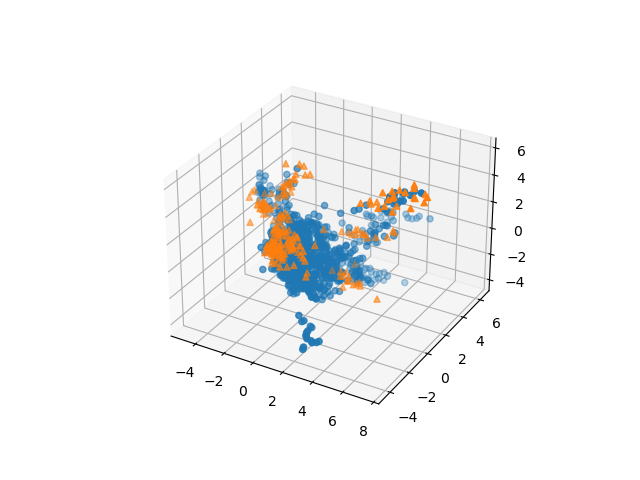

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(y_uv1[:,0], y_uv1[:,1], y_uv1[:,2], marker='o')
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax.scatter(y_uv0[:,0], y_uv0[:,1], y_uv0[:,2], marker='^')

C:\Users\17322\AppData\Local\Temp/ipykernel_4692/1864176785.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


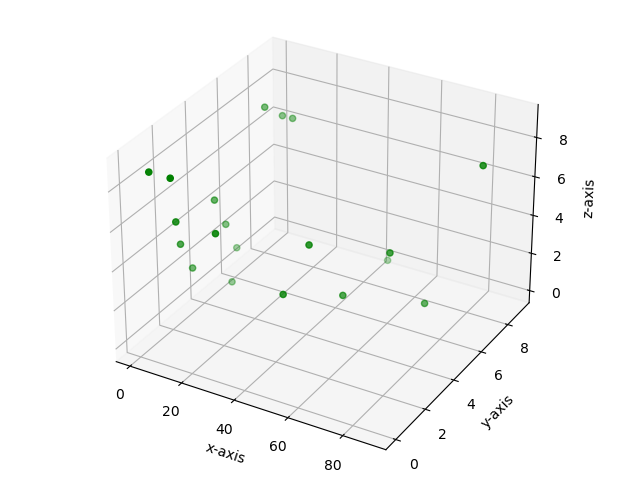

In [9]:

# creating 3d plot using matplotlib 
# in python
  
# for creating a responsive plot
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
  
# creating random dataset
xs = [14, 24, 43, 47, 54, 66, 74, 89, 12,
      44, 1, 2, 3, 4, 5, 9, 8, 7, 6, 5]
  
ys = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 3,
      5, 2, 4, 1, 8, 7, 0, 5]
  
zs = [9, 6, 3, 5, 2, 4, 1, 8, 7, 0, 1, 2, 
      3, 4, 5, 6, 7, 8, 9, 0]
  
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
plot_geeks = ax.scatter(xs, ys, zs, color='green')
  
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

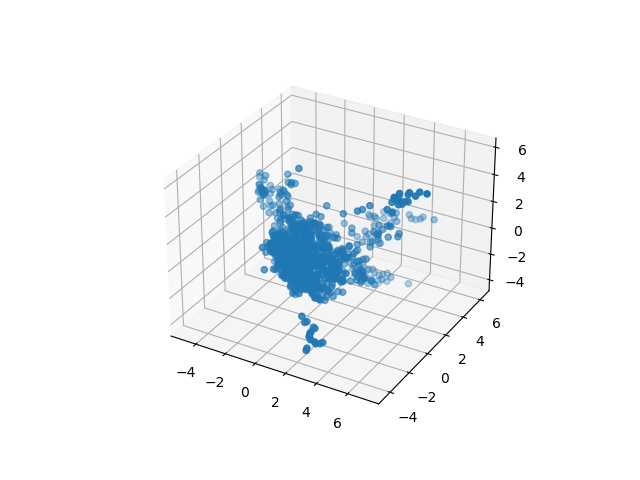

In [8]:
%matplotlib widget
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(y_uv1[:,0], y_uv1[:,1], y_uv1[:,2], marker='o')

# for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)

plt.show()

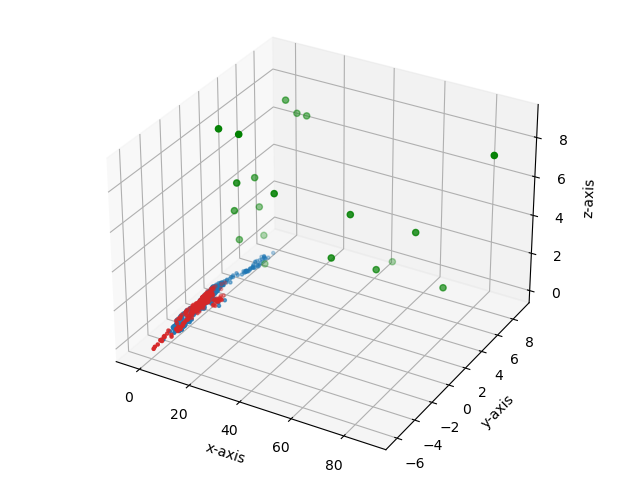

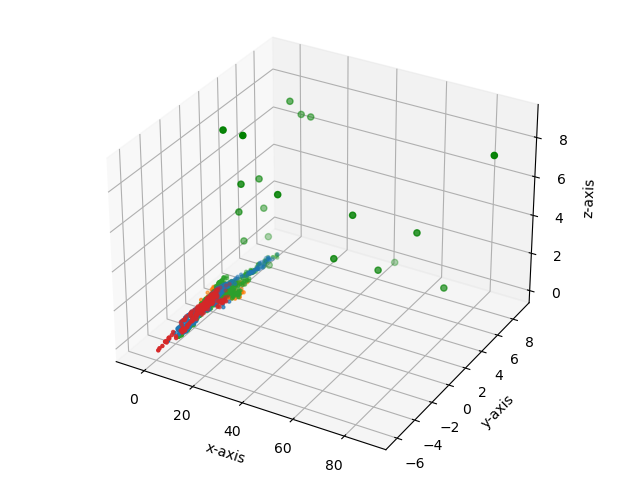

In [10]:
import numpy as np
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Random data of 100×3 dimension
# data = np.array(np.random.random((100, 3)))

# Scatter plot
# fig = plt.scatter(y_pos[:,0], y_pos[:,1], c='tab:red', s=5) # [:,0] I think means: the 0th element of every datapoint (x-coordinate)
# fig = plt.scatter(y_neg[:,0], y_neg[:,1], c='tab:blue', s=5)
fig = plt.scatter(y_v1[:,0], y_v1[:,1], c='tab:red', s=5) # [:,0] I think means: the 0th element of every datapoint (x-coordinate)
fig = plt.scatter(y_v0[:,0], y_v0[:,1], c='tab:blue', s=5)
plt.show()
fig = plt.scatter(y_uv1[:,0], y_uv1[:,1], c='tab:green', s=5) 
fig = plt.scatter(y_uv0[:,0], y_uv0[:,1], c='tab:orange', s=5)
plt.show()


# Old Code

## Load models

In [3]:
import torch
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

tokenizer

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PreTrainedTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [4]:
text = "At some point I had to decide: Have him <put to sleep>, or try to keep him alive a bit longer? If you think I'm cruel for wanting him to live on despite an illness-- I'm not cruel."
marked_text = "[CLS] " + text + " [SEP]"
# makred_text = text

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text, add_special_tokens=True)

# Print out the tokens.
print(tokenized_text)

Keyword arguments {'add_special_tokens': True} not recognized.


['[CLS]', 'at', 'some', 'point', 'i', 'had', 'to', 'decide', ':', 'have', 'him', '<', 'put', 'to', 'sleep', '>', ',', 'or', 'try', 'to', 'keep', 'him', 'alive', 'a', 'bit', 'longer', '?', 'if', 'you', 'think', 'i', "'", 'm', 'cruel', 'for', 'wanting', 'him', 'to', 'live', 'on', 'despite', 'an', 'illness', '-', '-', 'i', "'", 'm', 'not', 'cruel', '.', '[SEP]']


In [5]:
# optionally view the tokens
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

In [6]:
# # Define a new example sentence with multiple meanings of the word "bank"
# text = "After stealing money from the bank vault, the bank robber was seen " \
#        "fishing on the Mississippi river bank."

# # Add the special tokens.
# marked_text = "[CLS] " + text + " [SEP]"

# # Split the sentence into tokens.
# tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
at            2,012
some          2,070
point         2,391
i             1,045
had           2,018
to            2,000
decide        5,630
:             1,024
have          2,031
him           2,032
<             1,026
put           2,404
to            2,000
sleep         3,637
>             1,028
,             1,010
or            2,030
try           3,046
to            2,000
keep          2,562
him           2,032
alive         4,142
a             1,037
bit           2,978
longer        2,936
?             1,029
if            2,065
you           2,017
think         2,228
i             1,045
'             1,005
m             1,049
cruel        10,311
for           2,005
wanting       5,782
him           2,032
to            2,000
live          2,444
on            2,006
despite       2,750
an            2,019
illness       7,355
-             1,011
-             1,011
i             1,045
'             1,005
m             1,049
not           2,025
cruel        10,311


In [7]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [8]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [9]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [10]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [11]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 52
Number of hidden units: 768


In [12]:
# For the 5th token in our sentence, select its feature values from layer 5.
# token_i = 5
# layer_i = 5
# vec = hidden_states[layer_i][batch_i][token_i]

# # Plot the values as a histogram to show their distribution.
# plt.figure(figsize=(10,10))
# plt.hist(vec, bins=200)
# plt.show()

In [13]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 52, 768])


In [14]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 52, 768])

In [15]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 52, 768])

In [16]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([52, 13, 768])

## Obtaining Embeddings (choosing/pooling layers)

For word embeddings: you can pick which layer to extract from. Later layers will contain better contextualizations, but also represent states further in the pre-training process (i.e., representations specifically useful for the training objective (MLM and NSP), and maybe not necessarily good word embeddings). E.g., instead of using the last hidden layer all the time, people somestimes use the second-to-last layer. Or, they pool together layers, e.g. by taking the sum of all 12 layers, or the last 4 layers, etc. 

For sentence embeddings: a common approach is to average the word embeddings for the sentence to get a sort of "combined" embedding that represents the sentence. However... what does RoBERTa do for its classification? It can't be seen from the wrapper function `model()`.

### Word Embeddings

In [17]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 52 x 3072


In [18]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 52 x 768


In [19]:
print(token_vecs_sum[0])

tensor([ 1.9712e+00, -7.6230e-01, -1.5631e+00, -8.4866e-01, -3.0341e+00,
        -2.8601e-01,  9.8449e-01,  2.4162e+00,  1.6595e+00, -1.3633e+00,
         2.1191e+00,  5.9267e-01, -7.3240e-01,  3.4184e-01,  6.8901e-01,
         1.0582e+00, -5.7020e-01,  1.8236e+00,  4.9867e-01, -6.5045e-01,
         1.4117e-01,  7.4651e-01,  1.6412e+00,  4.4050e-01,  1.0822e+00,
        -4.5962e-02, -1.4027e+00,  4.6186e-02, -1.9273e+00,  9.6498e-01,
        -8.9398e-01, -4.3701e-01, -2.8740e+00, -1.1977e+00,  1.2804e+00,
         9.9858e-01,  7.7506e-01,  1.0183e+00, -6.4601e-01, -1.1300e+00,
        -1.7952e+00,  6.5990e-01, -4.0719e-01, -1.3727e-01, -1.3732e+00,
        -1.5159e+00, -1.8514e+01,  2.1378e+00, -2.7607e-01, -1.7314e+00,
         2.7743e+00, -5.2883e-01, -1.3559e+00,  2.4367e+00,  2.3788e+00,
         1.3756e+00, -1.9470e+00, -2.0980e-01, -3.3807e-01,  5.1359e-01,
         6.9552e-01,  2.0970e+00, -3.7182e-01, -3.1891e-01,  5.3281e-01,
         9.4899e-01,  5.4833e-01,  1.2908e+00, -1.1

### Sentence Embeddings

To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [20]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


In [21]:
print(sentence_embedding)

tensor([ 4.8057e-01,  1.2016e-01, -9.0135e-02, -2.8625e-01,  1.6841e-02,
         3.0069e-01,  9.5852e-02,  4.8213e-01,  2.0714e-01, -1.0908e-01,
         1.0874e-01, -2.4192e-01, -2.8447e-01,  2.3672e-01, -8.3680e-02,
         5.4495e-01,  1.2694e-01, -6.9681e-02, -1.0226e-01,  4.6104e-01,
         1.3928e-01,  3.2186e-02, -4.8699e-01,  4.8428e-01,  1.9134e-01,
         2.6170e-01, -7.8441e-02, -1.0360e-01, -3.2454e-01, -7.8828e-02,
         4.1087e-01,  2.2477e-01, -1.8853e-01, -2.0350e-01,  6.5876e-03,
        -2.9386e-01,  2.6023e-01, -2.4366e-01, -1.7201e-01,  3.3832e-02,
        -5.9201e-01, -9.7142e-02, -1.5267e-01, -1.5391e-01, -1.4795e-01,
        -9.8336e-02,  3.2561e-01, -2.5493e-01,  8.1344e-03, -6.3138e-01,
        -2.9514e-01,  2.6380e-01, -1.4358e-01, -1.6941e-01,  3.8295e-01,
         2.5456e-01,  1.4498e-01, -3.1078e-01, -3.4311e-01,  2.2050e-01,
        -5.3463e-01,  7.9443e-02,  4.3101e-01, -2.4205e-01, -2.0774e-01,
         1.5173e-01,  1.0985e-01,  4.0721e-01, -4.2

In [51]:
# here, I turn a 52x768 list of tensors into a 52x2 2D-numpy-array for plotting.
from sklearn.decomposition import PCA
import numpy as np

#pca = PCA(n_components=2)
#y = pca.fit(sentence_embedding)
print(len(token_vecs_sum))
print(len(token_vecs_sum[0]))
# print(type(token_vecs_sum))
# print(type(token_vecs_sum[0]))
# v = torch.empty()
X = np.zeros(shape=(52, 768))
for t in range(0, len(token_vecs_sum)):
    X[t] = np.array(token_vecs_sum[t])

print(type(X)) 
y = PCA(n_components=2).fit_transform(X)
y

52
768
<class 'numpy.ndarray'>


array([[  8.66513846,  -4.72738601],
       [  7.99977156,  28.38613427],
       [ 11.82433407,  36.11064119],
       [  9.26523889,  26.51372254],
       [ 17.01940397,   3.69006255],
       [ 11.43430355,  23.77780974],
       [ 10.34566159,  30.68171789],
       [ 15.28327464,  25.89548221],
       [ 14.05410391,  24.44847245],
       [ -7.89655806,  13.69064295],
       [-26.57633397,  -4.98456097],
       [ -1.55994365,  11.12037315],
       [-32.53076725,   0.11023029],
       [-27.02088415,   9.86282609],
       [-26.01747706,  -1.10214064],
       [  0.97145791,  11.13780138],
       [  4.65087731,   2.18599151],
       [ 13.04421468,  24.19959311],
       [  8.04250533,  19.45750517],
       [  7.4026681 ,  21.17933193],
       [-22.28317591,   4.96072942],
       [-30.03976897,  -6.11619026],
       [-34.659974  ,  -8.18140025],
       [-14.11663502,  14.48312863],
       [ -6.23670067,  14.827553  ],
       [-18.10159312,   7.46706921],
       [ 13.82432012,   8.15776679],
 

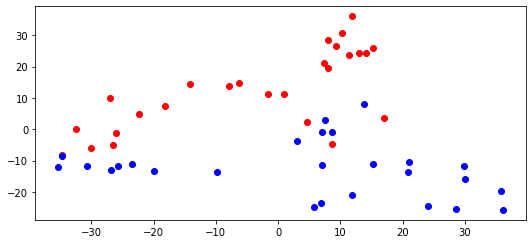

In [56]:
import numpy as np
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Random data of 100×3 dimension
# data = np.array(np.random.random((100, 3)))

# Scatter plot
plt.scatter(y[:26,0], y[:26,1], c='red') # [:,0] I think means: the 0th element of every datapoint (x-coordinate)
plt.scatter(y[26:52,0], y[26:52,1], c='blue')
# Display the plot
plt.show()